### Libraries

In [15]:
# Libraries
import pandas as pd
import numpy as np
import gspread
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

import os
os.chdir("..")  
from src import config
from src import help_functions as hf

# Configs
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)

### Import and quick check data

In [6]:
# Import and quick check Training data 
googleDrive_client = gspread.authorize(config.DRIVE_CREDENTIALS)
training_data, _ = hf.import_google_sheet(googleDrive_client=googleDrive_client, filename=config.DRIVE_TP_LOG_FILENAMES[0], sheet_index=0)

# "Clean" data
for col in training_data.columns:
    try:
        training_data[col] = training_data[col].apply(hf.safe_convert_to_numeric)
    except ValueError:
        pass 

# Date & Datetime
training_data["Date"] = pd.to_datetime(training_data[["Year", "Month", "Day"]]).dt.date
training_data["Datetime"] = pd.to_datetime(training_data[["Year", "Month", "Day"]])
training_data = training_data.sort_values(by="Date").reset_index(drop=True)

# About
print("Training data about:")
print("-----------------------------------------------------")
print("Todays date: {}".format(datetime.datetime.today().date()))
print("Date range: {} to {}".format(training_data["Date"].min(), training_data["Date"].max()))
print("Duplicated rows = {}".format(training_data[training_data.duplicated(keep=False)].shape[0]))
print("Missing dates = {}".format([d for d in pd.date_range(start=training_data["Date"].min(), end=training_data["Date"].max()).date if d not in training_data["Date"].values]))

print("\nDifferent activities and their counts:")
print("-------------------------------------")
activities_count_time = (
    training_data
    .groupby("Activity type")[["Duration [h]"]]
    .agg(
        count=("Duration [h]", "count"),
        total_duration=("Duration [h]", "sum")
        )
    .reset_index()
    .sort_values(by="total_duration", ascending=False)
    )

for _, row in activities_count_time.iterrows():
    print("{} ~> {:.2f} hours ({} act.)".format(row["Activity type"], row["total_duration"], row["count"]))

Training data about:
-----------------------------------------------------
Todays date: 2025-08-26
Date range: 2024-09-13 to 2025-08-25
Duplicated rows = 0
Missing dates = []

Different activities and their counts:
-------------------------------------
Trail Running ~> 281.08 hours (151 act.)
Road Biking ~> 80.82 hours (33 act.)
Running ~> 78.25 hours (76 act.)
Indoor Biking ~> 71.04 hours (51 act.)
Mountain Biking ~> 16.99 hours (9 act.)
Hiking ~> 15.35 hours (6 act.)
Road biking ~> 3.74 hours (2 act.)
Lap Swimming ~> 0.21 hours (1 act.)


In [7]:
# Import and quick check Daily data
googleDrive_client = gspread.authorize(config.DRIVE_CREDENTIALS)
daily_data, _ = hf.import_google_sheet(googleDrive_client=googleDrive_client, filename=config.DRIVE_TP_LOG_FILENAMES[1], sheet_index=0)

# "Clean" data
for col in daily_data.columns:
    try:
        daily_data[col] = daily_data[col].apply(hf.safe_convert_to_numeric)
    except ValueError:
        pass 

# Date & Datetime
daily_data["Date"] = pd.to_datetime(daily_data[["Year", "Month", "Day"]]).dt.date
daily_data["Datetime"] = pd.to_datetime(daily_data[["Year", "Month", "Day"]])
daily_data = daily_data.sort_values(by="Date").reset_index(drop=True)

# About
print("Daily data about:")
print("-----------------------------------------------------")
print("Todays date: {}".format(datetime.datetime.today().date()))
print("Date range: {} to {}".format(daily_data["Date"].min(), daily_data["Date"].max()))
print("Duplicated rows = {}".format(daily_data[daily_data.duplicated(keep=False)].shape[0]))
print("Missing dates = {}".format([d for d in pd.date_range(start=daily_data["Date"].min(), end=daily_data["Date"].max()).date if d not in daily_data["Date"].values]))

Daily data about:
-----------------------------------------------------
Todays date: 2025-08-26
Date range: 2024-04-15 to 2025-08-25
Duplicated rows = 0
Missing dates = []


### Relative training Load (RTL)

Data preparation:
- We will take all activities into account regardless if it was real training or not (including Hiking and Swimming or cycling with my girlfriend).
- Given the above, and since in principle I only have one "real" workout per day, we will calculate the total training load in the day, so that each sample is one day. This also solves the problem of the "not real" workouts mentioned above. However, if we could have more serious workouts in the day, we would consider each sample one workout and in order not to distort the TL data, we would want to discard everything that is not a real workout.

Formal definitions:
- $TL_t$ - Training load of the day t
- $TL_{\text{avg},t} = \frac{1}{n} \sum_{i=1}^{n} TL_{t}$ - recent Average Load over n days
- $TL_{\text{max},t} = \max(TL_{t-1}, TL_{t-2}, \dots, TL_{t-n})$ - recent peak load over n sessions
- $RTL_{\text{avg},t} = \frac{TL_t}{TL_{\text{avg},t}}$ - relative to recent average
- $RTL_{\text{peak},t} = \frac{TL_t}{TL_{\text{max},t}}$ - relative to recent peak
- $RTL^*_t = \alpha \cdot RTL_{\text{avg},t} + (1 - \alpha) \cdot RTL_{\text{peak},t} \quad 0 \le \alpha \le 1$ - Composite Metric

Notes:
- Using a rolling average (TL_avg) or rolling peak (TL_max) captures your recent training state. It contextualizes today’s session: a 300 TRIMP session might be heavy for someone who has only done 200 TRIMP sessions recently, but normal for someone consistently doing 400.
- RTL_avg shows relative load compared to baseline adaptation (sustained training).
- RTL_peak shows relative load compared to recent maximum stress, highlighting spikes that may be riskier.
- Combining them with a weight α gives a balanced view, accounting for both consistency and acute stress.

Potential improvements:
- Instead of a fixed n sessions, you could weight recent sessions more (exponential moving average): $TL_{\text{EMA},t} = \frac{\sum_{i=1}^{n} TL_{t-i} \cdot \lambda^{i-1}}{\sum_{i=1}^{n} \lambda^{i-1}}, \quad 0 < \lambda \le 1$.
- Nonlinear combination of average and peak. Sometimes spikes should count more than their linear weight: $RTL^*_t = \left(RTL_{\text{avg},t}\right)^\beta \cdot \left(RTL_{\text{peak},t}\right)^{1-\beta}, \quad \beta \in [0,1]$.
- Multi-metric composite. Instead of using just TL, we could combine distance, duration, and intensity into a single RTL vector: $\mathbf{RTL}_t = [RTL_{TL,t}, RTL_{D,t}, RTL_{T,t}, RTL_{HR,t}]$
- Fatigue / readiness adjustment. Relative load could be normalized by recovery metrics (HRV, sleep, resting HR): $TL_{\text{adj},t} = \frac{RTL_t}{1 + f(\text{HRV}_t, \text{rest}_t)}$

Benefits:
- Captures context: It tells you if today’s session is heavy relative to your current state.
- Avoids overtraining risk: spikes above recent peak are immediately visible.
- Enables better training decisions: you can plan lighter or heavier sessions relative to recent load.
- Makes metrics comparable across athletes or periods by using ratios rather than absolute values.

Additional: Using RTL for smarter periodization
- The classic idea: you don’t just train hard every day. You want to match training stress to recent load and recovery, which is essentially auto-regulated periodization.
- Low recent load - higher intensity is safe - RTL will be below 1, signaling that a spike is acceptable.
- High recent load - reduce intensity - If RTL is already above 1 (or near peak), adding a hard session risks overtraining or injury.
- Goal: structured variation - microcycle approach. 
- This is where the above potential improvements help: 
    - Exponential weighting for recent load - metric is sensitive to very recent fatigue.
    - Nonlinear combination of avg and peak - Spikes in load are highlighted more strongly.
    - Multi-metric RTL - You might have a “distance-heavy” day but low intensity, or vice versa. (High RTL_distance - limit long runs & High RTL_HR - limit high-intensity intervals).
    - Recovery-adjusted RTL - You can have a “hard” day only if both recent load is low and body is ready.

$$
\text{Next session intensity} =
\begin{cases} 
\text{Hard}, & \text{if } RTL_{\text{adj}} < 0.8 \\[2mm]
\text{Moderate}, & \text{if } 0.8 \le RTL_{\text{adj}} \le 1.2 \\[1mm]
\text{Easy / Recovery}, & \text{if } RTL_{\text{adj}} > 1.2
\end{cases}
$$

You can tune the thresholds based on athlete type, sport, or training phase. This produces an adaptive low-low-hard pattern automatically.

### Quantify last training to recent trainings - Recent Load Relative Percentile (RLRP)

We want to know how hard is today's training compared to what we're used to?

We need a method that measures where this new session stands compared to the whole distribution of recent sessions, while giving more weight to recent training (since that reflects current adaptation).

Training loads (TLs) are typically right-skewed (many easy sessions, few very hard sessions). So, if we assume normality directly, it doesn’t fit well. Solution: log-transform the TLs - This allows us to use familiar tools (mean, std, z-scores) while respecting the actual structure of training data.

$x_i = \log(TL_i), \quad i = 1, \dots, n$

Weighting Recent Sessions: A workout from 3 weeks ago is less relevant than yesterday's. To capture this, we use exponential weighting: recent sessions get higher weights and older sessions still matter, but their influence fades.

$w_i = \lambda^{i-1}, \quad 0 < \lambda < 1$

We now create a weighted distribution of recent log-TLs:

$\mu_w = \sum_{i=1}^n \tilde{w}_i \, x_i$ 

$\sigma_w^2 = \sum_{i=1}^n \tilde{w}_i \, (x_i - \mu_w)^2$

Then we quantify today's session with load $TL_{new}$:

1. Log transform:
$x_{\text{new}} = \log(TL_{\text{new}})$

2. Compute z-score:
z = \frac{x_{\text{new}} - \mu_w}{\sigma_w}$

3. Convert to percentile (optional):
p=Φ(z)


Notes: 
- Logarithm compresses the upper tail of the distribution. Big TL values (very hard sessions) get “squeezed” closer to the middle - very hard sessions become “less extreme” in log-space.
- Using log-transform: Makes the distribution roughly symmetric - normal approximation works.
- A TL that was "extremely hard" in raw terms might have a slightly lower percentile than raw comparison. But it still shows as above average; z-score will still be positive.
- Care about relative changes, not absolute. A jump from 200 to 300 TRIMP (50% increase) is more significant than from 600 to 700 TRIMP (16.7% increase). Log-transform captures this better.
- Large peaks matter less, which may be undesirable if you want to capture peak risk.
- If you want to emphasize extreme sessions more, you could consider:
    - No log-transform + weighted percentile - keeps raw differences.
    - Nonlinear transformation (e.g., square root) → less extreme than raw, but not as compressive as log.

Hybrid idea: Sometimes people compute both and track them:
- Raw RLRP for operational/hedging relevance.
- Log-RLRP for trend detection and anomaly scoring.

Raw RLRP Definition:

Let $L_t$ be the load at time $t$, and let $\mathcal{H}_t = \{L_{t-1}, L_{t-2}, \dots, L_{t-N}\}$ be the recent historical load values over the last $N$ periods. Let $w_i$ be the weight for each historical observation. Then the Raw RLRP for time $t$ is defined as the weighted percentile of $L_t$ relative to $\mathcal{H}_t$:

$\text{RLRP}_t = P_w(L_t \mid \mathcal{H}_t, \mathbf{w})$, where $P_w$ denotes the weighted percentile function.

Sort $\mathcal{H}_t$ in ascending order: 

$L_{(1)} \le L_{(2)} \le \dots \le L_{(N)}$.
Compute the cumulative weights: 

$C_j = \sum_{i=1}^{j} w_{(i)}, \quad j = 1, \dots, N$

Normalize the cumulative weights: 
$F_j = \frac{C_j}{\sum_{i=1}^{N} w_i}$

The RLRP is the value $L_{(k)}$ such that:

$F_{k-1} \le \frac{L_t - \min(\mathcal{H}_t)}{\max(\mathcal{H}_t) - \min(\mathcal{H}_t)} \le F_k$

Or in simpler, weighted percentile terms: $L_{(k)}$ such that: 
$text{RLRP}_t = L_{(k)}$, where $\quad k = \min \{ j : F_j \ge p \}, \quad p = \text{percentile rank of } L_t$

# LETS GO!

In [68]:
# Prepare data
tl_data = (
    training_data[["Datetime", "Training load"]].copy()
    .groupby("Datetime").sum().reset_index()
    .assign(**{"Date index": lambda x: np.arange(x.shape[0])[::-1] + 1})
)

# Rest day - TL = 0
tl_data

,Datetime,Training load,Date index
0,2024-09-13,129.8,347
1,2024-09-14,48.5,346
2,2024-09-15,229.8,345
3,2024-09-16,140.9,344
4,2024-09-17,119.0,343
...,...,...,...
342,2025-08-21,64.5,5
343,2025-08-22,193.9,4
344,2025-08-23,87.6,3
345,2025-08-24,239.1,2


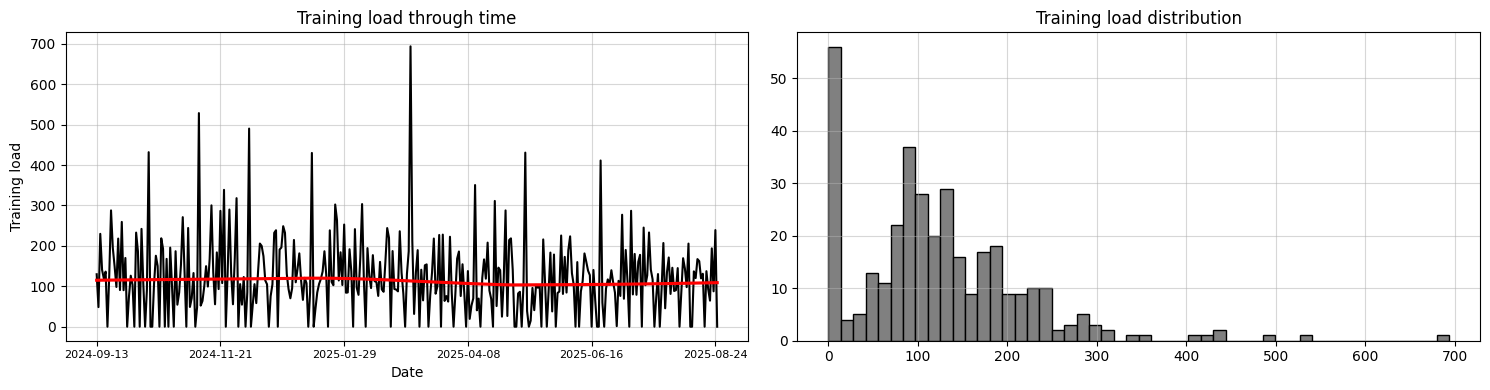

In [ ]:
# Exploratory data analysis - EDA
fig, ax = plt.subplots(1,2,figsize=(15, 4))
indices = np.arange(tl_data.shape[0])

# Training load trough time
ax[0].set_title("Training load through time")
ax[0].plot(indices, tl_data["Training load"], color="black")
sns.regplot(x=indices, y=tl_data["Training load"], scatter=False, lowess=True, color="red", ax=ax[0])

ax[0].set_xticks(indices[::max(1, len(indices)//5)])  
ax[0].set_xticklabels(tl_data["Datetime"].dt.strftime("%Y-%m-%d")[::max(1, len(indices)//5)], fontsize=8, rotation=0)
ax[0].set_xlabel("Date")
ax[0].set_ylabel("Training load")

# Training load distribution
ax[1].set_title("Training load distribution")
ax[1].hist(tl_data["Training load"], bins=50, color="grey", edgecolor="black")

for i in [0,1]:
    ax[i].grid(alpha=.5)
        
plt.tight_layout()
plt.show()

<Axes: title={'center': 'Training load and recent average (28 days)'}, xlabel='Datetime'>

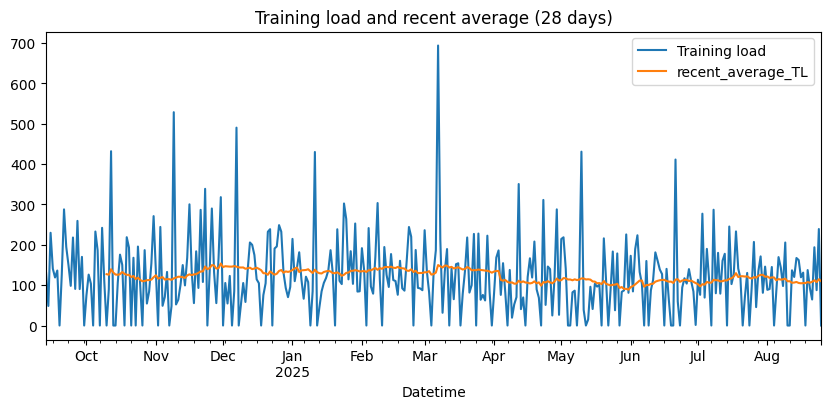

In [86]:
# Recent Average load over n days (n = 28) 
tl_data["recent_average_TL"] = tl_data["Training load"].rolling(window=28, min_periods=28).mean()
tl_data.plot(x="Datetime", y=["Training load", "recent_average_TL"], figsize=(10,4), title="Training load and recent average (28 days)")

<Axes: title={'center': 'Training load and recent peak (28 days)'}, xlabel='Datetime'>

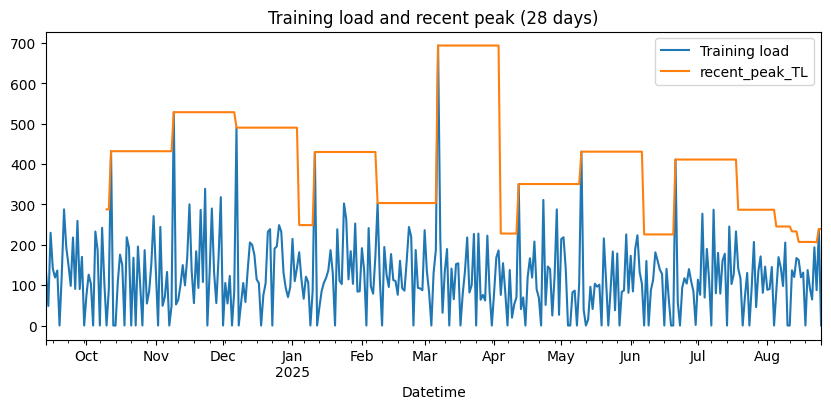

In [87]:
# Recent peak load over n days (n = 28)
tl_data["recent_peak_TL"] = tl_data["Training load"].rolling(window=28, min_periods=28).max()
tl_data.plot(x="Datetime", y=["Training load", "recent_peak_TL"], figsize=(10,4), title="Training load and recent peak (28 days)")

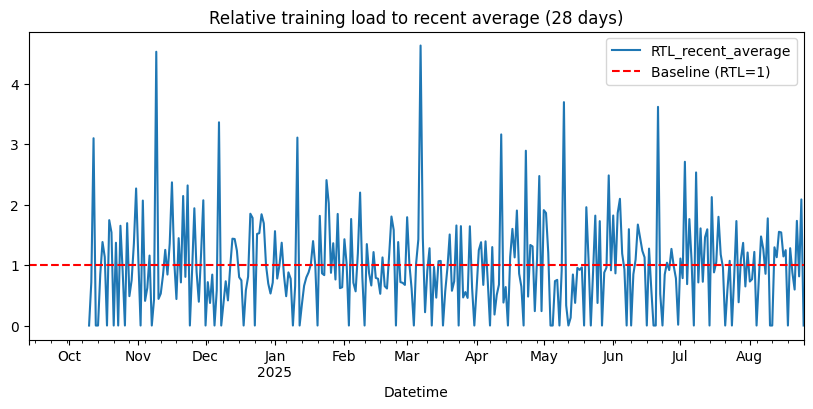

In [92]:
# Relative to recent average 
tl_data["RTL_recent_average"] = tl_data["Training load"] / tl_data["recent_average_TL"]
ax = tl_data.plot(x="Datetime", y=["RTL_recent_average"], figsize=(10,4), title="Relative training load to recent average (28 days)")
ax.axhline(y=1, color='red', linestyle='--', label='Baseline (RTL=1)')
ax.legend()

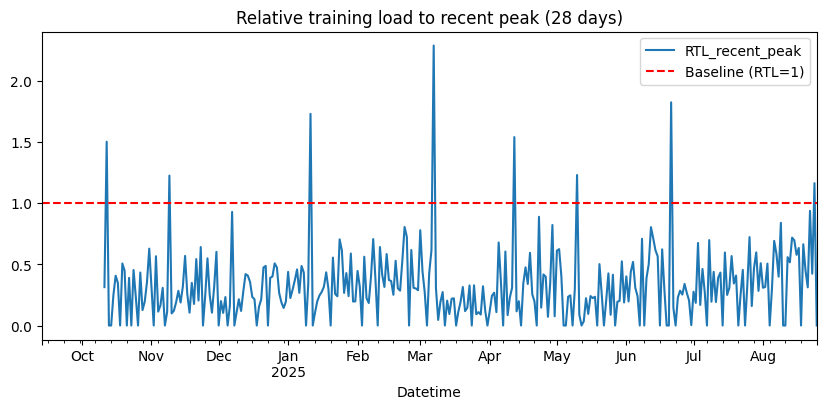

In [101]:
# Relative to recent peak

tl_data["recent_peak_TL_excl_current"] = (
    tl_data["Training load"].shift(1) 
    .rolling(window=28, min_periods=28)
    .max()
)
tl_data["RTL_recent_peak"] = tl_data["Training load"] / tl_data["recent_peak_TL_excl_current"]
ax = tl_data.plot(x="Datetime", y=["RTL_recent_peak"], figsize=(10,4), title="Relative training load to recent peak (28 days)")
ax.axhline(y=1, color='red', linestyle='--', label='Baseline (RTL=1)')
ax.legend()

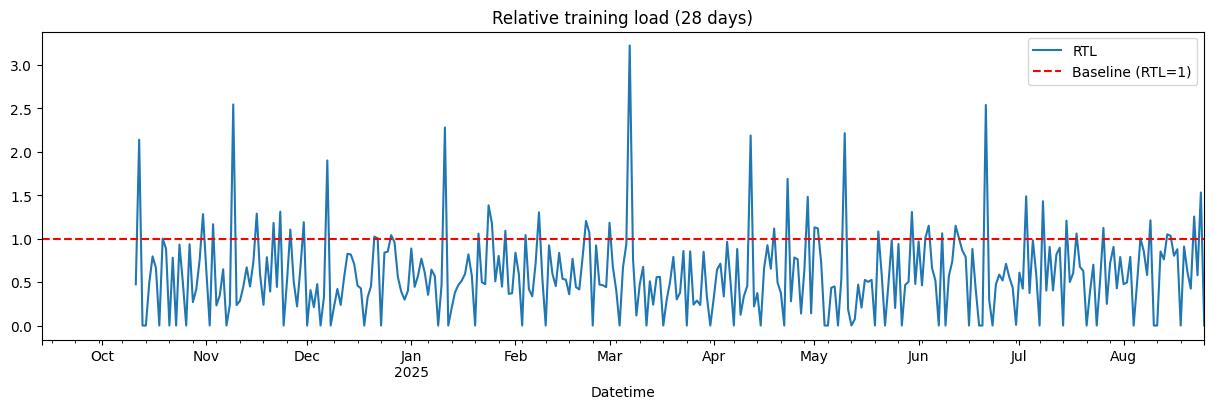

In [120]:
# Relative training Load RTL = alpha * RTL(relative avg.) + (1-alpha) * RTL(relative peak)
# --> alpha = 0.4 . slightly favor peak for spike-sensitive or injury risk monitoring
alpha = 0.4
tl_data["RTL"] = alpha * tl_data["RTL_recent_average"] + (1 - alpha) * tl_data["RTL_recent_peak"]

# ax = tl_data.plot(x="Datetime", y=["RTL", "RTL_recent_average", "RTL_recent_peak"], figsize=(15,4), title="Relative training load (28 days)", alpha=1)
ax = tl_data.plot(x="Datetime", y=["RTL"], figsize=(15,4), title="Relative training load (28 days)", alpha=1)
ax.axhline(y=1, color='red', linestyle='--', label='Baseline (RTL=1)')
ax.legend()